# Linear Static and Vibration Analysis of Bernoulli Frames

This notebook demonstrates how to use **pyaxisvm** to build and analyze 3d frames. We will build a scalable model, consisting of a grid of Bernoulli beams, and perform a linear static analysis and a linear vibration analysis. We will use `NumPy` to store and handle numerical data and `PolyMesh` for grid generation.

## Input Data

Python has a waste number of third party packages, that might save you dozens of time. Now we are going to use the `PolyMesh` library to create a grid of lines. The following lines contain all input parameters of the calculations. After modifying these, the rest should work.

In [5]:
# the size of the grid
Lx, Ly, Lz = 10., 2.0, 1.0

# these control subdivision
# set these higher if you want more lines in the same space
nx, ny, nz = 4, 2, 2  

# data of a CHS section
D = 0.1  # outer diameter of the tube in m
t = 0.05  # thickness of the tube in m

# value of the concentrated force at the free end in kN
# and the number of load cases to generate
F = 1.0 
nCase = 5  


### Mesh Creation

We can create a 3d grid of bernoulli beams using the `PolyMesh` library. After it, we are going to have our mesh as two `NumPy` arrays, `coords` for the coordinates and `topo` for nodal connectivity. We will use these to build our AxisVM model.

In [6]:
from polymesh.space import StandardFrame, PointCloud
from polymesh.grid import gridH8 as grid
from polymesh.topo.tr import H8_to_L2
import numpy as np

# mesh
gridparams = {
    'size': (Lx, Ly, Lz),
    'shape': (nx, ny, nz),
    'origo': (0, 0, 0),
    'start': 0
}

# create a grid of hexagonals
coords, topo = grid(**gridparams)

# turn the hexagonal mesh into lines
coords, topo = H8_to_L2(coords, topo)

GlobalFrame = StandardFrame(dim=3)

# define a pointcloud
points = PointCloud(coords, frame=GlobalFrame).centralize()

# set the origo to the center of the fixed end
dx = - np.array([points[:, 0].min(), 0., 0.])
points.move(dx)

# get the coordinates of the vectors
coords = points.show()


## AxisVM

Starting an AxisVM instance is easy. If in a Jupyter Notebook, drop the interface and watch a html represantation of it, which summarizes the version of the application and the type library as well.

In [7]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)
axvm


IAxisVMApplication,Information
AxisVM Platform,64 bit
AxisVM Version,15 r4r En 0
Type Library Version,15 401


In [8]:
import axisvm.com.tlb as axtlb

# create new model
modelId = axvm.Models.New()
axm = axvm.Models[modelId]

# material
ndc, material = axtlb.ndcEuroCode, "S 235"
axm.Settings.NationalDesignCode = ndc

# cross section
MaterialIndex = axm.Materials.AddFromCatalog(ndc, material)
CrossSectionIndex = axm.CrossSections.AddCircleHollow('S1', D, t)

# crate nodes
fnc = axm.Nodes.Add
list(map(lambda c: fnc(*c), coords))

# create lines
fnc = axm.Lines.Add
GeomType = axtlb.lgtStraightLine
list(map(lambda x: fnc(x[0], x[1], GeomType), topo + 1))

# set material and cross section
LineAttr = axtlb.RLineAttr(
    LineType=axtlb.ltBeam,
    MaterialIndex=MaterialIndex,
    StartCrossSectionIndex=CrossSectionIndex,
    EndCrossSectionIndex=CrossSectionIndex
)
lineIDs = [i+1 for i in range(axm.Lines.Count)]
attributes = [LineAttr for _ in range(axm.Lines.Count)]
axm.Lines.BulkSetAttr(lineIDs, attributes)

# nodal supports
spring = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=1e12, yy=1e12, zz=1e12)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(x=0, y=0, z=0, xx=0, yy=0, zz=0)
ebcinds = np.where(coords[:, 0] < 1e-12)[0]
for i in ebcinds:
    axm.NodalSupports.AddNodalGlobal(spring, RNonLinearity, RResistances, i+1)

# nodal loads
load_cases = {}
LoadCaseType = axtlb.lctStandard
inds = np.where(coords[:, 0] > Lx - 1e-12)[0] + 1
axm.BeginUpdate()
for case in range(nCase):
    name = 'LC{}'.format(case+1)
    lcid = axm.LoadCases.Add(name, LoadCaseType)
    pid = np.random.choice(inds)
    Fx, Fy, Fz = 0, 0, -F
    force = axtlb.RLoadNodalForce(
        LoadCaseId=lcid,
        NodeId=pid,
        Fx=Fx, Fy=Fy, Fz=Fz,
        Mx=0., My=0., Mz=0.,
        ReferenceId=0
    )
    axm.Loads.AddNodalForce(force)
    load_cases[lcid] = dict(name=name, id=case)
axm.EndUpdate()

# save the model before calculation
fpath = 'the_name_of_your_file.axs'
axm.SaveToFile(fpath, False)
axm


IAxisVMModel,Information
N Nodes,45
N Lines,96
N Members,96
N Surfaces,0
N Domains,0


## Linear Static Analysis

We can perform a linear elastic static analysis with the following command:

In [9]:
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)

1

You can make a screenshot anytime!

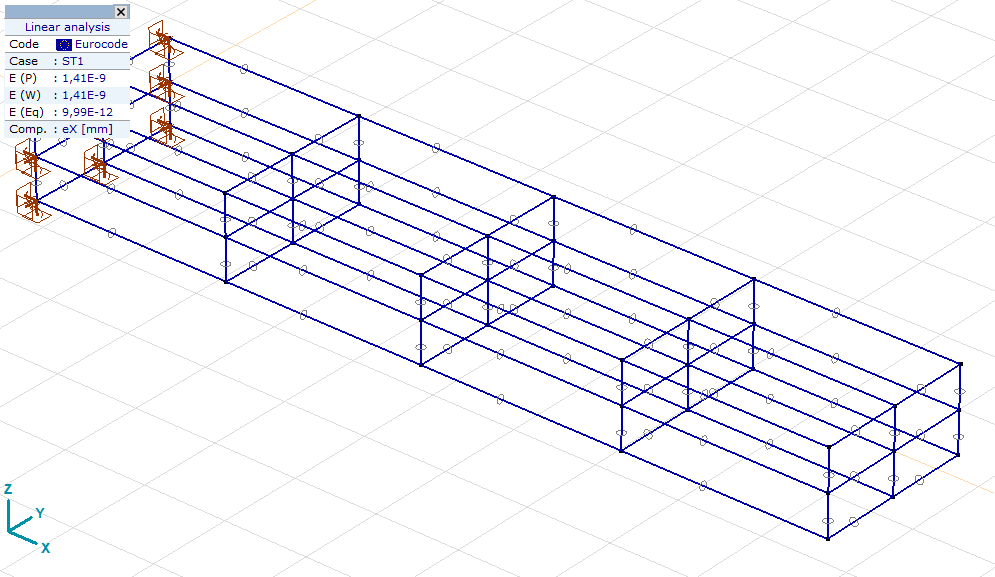

In [10]:
axvm.BringToFront()
axm.View = axtlb.vPerspective
axvm.MainFormTab = axtlb.mftStatic
axm.FitInView()
axm.Windows[1].screenshot()

The following block fetches displacements for all nodes and load cases in the model and stores it in a `NumPy` array. You can use this block as a template in any of your future workflows.

In [11]:
disps = axm.Results.Displacements
disps.DisplacementSystem = axtlb.dsGlobal
disps.LoadLevelOrModeShapeOrTimeStep = 1
dofsol = np.zeros((axm.Nodes.Count, 3, nCase))
for lcid, lcdata in load_cases.items():
    lcname = lcdata['name']  # retrieve the name of the load case
    disps.LoadCaseId = lcid
    load_case_id = lcdata['id']
    for nodeId in range(axm.Nodes.Count):
        d = disps.NodalDisplacementByLoadCaseId(i+1)[0]
        dofsol[nodeId, 0, load_case_id] = d.ex
        dofsol[nodeId, 1, load_case_id] = d.ey
        dofsol[nodeId, 2, load_case_id] = d.ez
dofsol[np.where(np.abs(dofsol) < 0.00001)] = 0.0  # trim very small values

The array has values for all 45 nodes, 3 spatial dimensions and 5 load cases

In [12]:
dofsol.shape

(45, 3, 5)

## Vibration Analysis

The following block performs a vibration analysis for the first load case.

In [13]:
options = axtlb.RVibration(
    LoadCase = 1,
    Iterations = 30,
    ModeShapes = 15,
    EigenValueConvergence = 1e-3,
    EigenVectorConvergence = 1e-3,
    MassControl = axtlb.mcMassesOnly,
    ConvertLoadsToMasses = False,
    ConcentratedMasses = False,
    ConvertConcentratedMassesToLoads = False,
    ElementMasses = True,
    MassComponentX = True,
    MassComponentY = True,
    MassComponentZ = True,
    ConvertSlabsToDiaphragms = False,
    MassMatrixType = axtlb.mtConsistent,
    IncreasedSupportStiffness = False,
    MassesTakenIntoAccount=axtlb.mtiaAll
)
interaction = axtlb.cuiNoUserInteractionWithAutoCorrectNoShow
axm.Calculation.Vibration(options, interaction)

 1]

Execute this line to get the natural circular frequencies:

In [14]:
freks, _ = axm.Results.GetAllFrequencies(axtlb.atLinearVibration, 1)
freks

(2.959385451831059,
 3.0874871771922074,
 4.2843169427821906,
 9.185151639376052,
 9.515214328710275,
 12.974291945228083,
 15.96847008498523,
 16.552764989633506,
 21.82392993055216,
 21.869449619700013,
 22.11765361461048,
 28.831941430030103,
 61.843802681433814,
 63.1993862629429,
 67.8132972985758)

You can also get modal mass factors. It is easy to read out from the results, that the first two modes correspond to bending shapes.

In [15]:
records, _ = axm.Results.GetAllModalMassfactors(axtlb.atLinearVibration, 1)
records = np.array([[r.x, r.y, r.z] for r in records])
records[np.where(records < 0.001)] = 0.0  # rule out small values
records *= 100  # to get percentage values
records

array([[ 0.        , 74.60765839,  0.        ],
       [ 0.        ,  0.        , 74.40606356],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  8.9579545 ,  0.        ],
       [ 0.        ,  0.        ,  9.68592092],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.84366924,  0.        ],
       [ 0.        ,  0.        ,  2.56371368],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.7027301 ,  0.        ],
       [ 0.        ,  0.        ,  0.55825803],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

Finally, close AxisVM if you are done.

In [16]:
axvm.Quit()